# **Importação de bibliotecas**

In [1]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Versões das bibliotecas utilizadas:")
print(f"- Pandas: {pd.__version__}")
print(f"- NumPy: {np.__version__}")
print(f"- Matplotlib: {plt.matplotlib.__version__}")
print(f"- Seaborn: {sns.__version__}")

Versões das bibliotecas utilizadas:
- Pandas: 2.1.4
- NumPy: 1.26.3
- Matplotlib: 3.8.0
- Seaborn: 0.12.2


# **Conversão de ODS para CSV**

In [3]:
try:
    import odf
except ImportError:
    print("Instalando biblioteca odfpy...")
    !pip install odfpy
    print("Instalação concluída!")

Instalando biblioteca odfpy...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160672 sha256=244a580363f3a2f5542a544260d2f785f2d38de23defdc0a5b5c05924a9958f9
  Stored in directory: /home/leandro/.var/app/com.visualstudio.code/cache/pip/wheels/d6/1d/c8/8c29be1d73ca42d15977c75193d9f39a98499413c2838ac54c
Successfully built odfpy
Instalação concluída!


In [4]:
import pandas as pd
import os

caminho_arquivo_ods = "dados_projeto.ods"
caminho_arquivo_csv = "dados_projeto.csv"

if os.path.exists(caminho_arquivo_ods):
    print(f"Arquivo ODS encontrado: {caminho_arquivo_ods}")
    
    df = pd.read_excel(caminho_arquivo_ods, engine='odf')
    
    print("\nInformações do dataset carregado:")
    print(f"- Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    print(f"- Colunas: {list(df.columns)}")
    print("\nPrimeiras 5 linhas do dataset:")
    print(df.head())
    
    df.to_csv(caminho_arquivo_csv, index=False, encoding='utf-8')
    
    print(f"\nArquivo convertido e salvo como: {caminho_arquivo_csv}")
    print("Conversão concluída com sucesso!")
    
else:
    print(f"ERRO: Arquivo {caminho_arquivo_ods} não encontrado.")
    print("Verifique se o arquivo está na pasta correta: projeto_tarifa_onibus_cg/")

Arquivo ODS encontrado: dados_projeto.ods

Informações do dataset carregado:
- Dimensões: 27 linhas x 7 colunas
- Colunas: ['data', 'valor_tarifa', 'ipca_variacao_acumulada_ano_base', 'ipca_variacao_mensal_acumulada', 'salario_minimo_real', 'valor_tarifa_real_ipca', 'valor_tarifa_real_igpm']

Primeiras 5 linhas do dataset:
        data  valor_tarifa  ipca_variacao_acumulada_ano_base  \
0 1999-07-12          1.00                              8.94   
1 2001-01-25          1.15                              7.67   
2 2002-05-13          1.35                             12.53   
3 2003-02-25          1.70                              9.30   
4 2004-03-17          1.80                              7.60   

   ipca_variacao_mensal_acumulada  salario_minimo_real  \
0                             NaN               666.37   
1                           10.53               673.01   
2                            9.70               798.44   
3                           11.87               688.05   


# **Limpeza e tratamento dos dados**

## Conversão de data e variáveis temporais

In [5]:
# Converter a coluna 'data' para o tipo datetime
df['data'] = pd.to_datetime(df['data'])

df = df.sort_values('data').reset_index(drop=True)

df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month
df['dia'] = df['data'].dt.day

# Verificar a conversão
print("Conversão de datas concluída:")
print(f"Tipo da coluna 'data': {df['data'].dtype}")
print(f"Período coberto: {df['data'].min().strftime('%d/%m/%Y')} a {df['data'].max().strftime('%d/%m/%Y')}")
print(f"Total de reajustes tarifários: {len(df)}")

Conversão de datas concluída:
Tipo da coluna 'data': datetime64[ns]
Período coberto: 12/07/1999 a 23/01/2025
Total de reajustes tarifários: 27


## Indicador da relação tarifa-salário

In [6]:
# Percentual do salário mínimo que a tarifa REAL representa (usando IGP-M)
df['tarifa_real_igpm_sobre_salario_percentual'] = (df['valor_tarifa_real_igpm'] / df['salario_minimo_real']) * 100

# Percentual do salário mínimo que a tarifa REAL representa (usando IPCA)
df['tarifa_real_ipca_sobre_salario_percentual'] = (df['valor_tarifa_real_ipca'] / df['salario_minimo_real']) * 100

## Indicadores de Variação Percentual e Elasticidade

In [7]:
# Variação percentual entre reajustes - VALORES REAIS (IGP-M)
df['variacao_percentual_real_igpm'] = df['valor_tarifa_real_igpm'].pct_change() * 100

# Variação percentual entre reajustes - VALORES REAIS (IPCA) para comparação
df['variacao_percentual_real_ipca'] = df['valor_tarifa_real_ipca'].pct_change() * 100

# Variação percentual do salário mínimo real entre reajustes
df['variacao_percentual_salario_real'] = df['salario_minimo_real'].pct_change() * 100

# Elasticidade-tarifa REAL (sensibilidade da tarifa real em relação ao salário real)
# Elasticidade = Variação % da Tarifa REAL (IGP-M) / Variação % do Salário REAL
df['elasticidade_tarifa_real_salario_igpm'] = df['variacao_percentual_real_igpm'] / df['variacao_percentual_salario_real']

# Também calculando com IPCA para comparação
df['elasticidade_tarifa_real_salario_ipca'] = df['variacao_percentual_real_ipca'] / df['variacao_percentual_salario_real']

# Tratar casos de divisão por zero ou valores infinitos
df['elasticidade_tarifa_real_salario_igpm'] = df['elasticidade_tarifa_real_salario_igpm'].replace([np.inf, -np.inf], np.nan)
df['elasticidade_tarifa_real_salario_ipca'] = df['elasticidade_tarifa_real_salario_ipca'].replace([np.inf, -np.inf], np.nan)

In [8]:
df.head()

,data,valor_tarifa,ipca_variacao_acumulada_ano_base,ipca_variacao_mensal_acumulada,salario_minimo_real,valor_tarifa_real_ipca,valor_tarifa_real_igpm,ano,mes,dia,tarifa_real_igpm_sobre_salario_percentual,tarifa_real_ipca_sobre_salario_percentual,variacao_percentual_real_igpm,variacao_percentual_real_ipca,variacao_percentual_salario_real,elasticidade_tarifa_real_salario_igpm,elasticidade_tarifa_real_salario_ipca
0,1999-07-12,1.00,8.94,NaN,666.37,4.83,7.36,1999,7,12,1.104491,0.724823,NaN,NaN,NaN,NaN,NaN
1,2001-01-25,1.15,7.67,10.53,673.01,5.00,6.94,2001,1,25,1.031188,0.742931,-5.706522,3.519669,0.996443,-5.726890,3.532231
2,2002-05-13,1.35,12.53,9.70,798.44,5.33,7.30,2002,5,13,0.914283,0.667552,5.187320,6.600000,18.637167,0.278332,0.354131
3,2003-02-25,1.70,9.30,11.87,688.05,5.97,7.25,2003,2,25,1.053702,0.867670,-0.684932,12.007505,-13.825710,0.049540,-0.868491
4,2004-03-17,1.80,7.60,8.07,763.90,5.83,7.11,2004,3,17,0.930750,0.763189,-1.931034,-2.345059,11.023908,-0.175168,-0.212725


### Retirando os horários que ficaram na variável 'data'

In [9]:
# Converter para datetime e depois para date (remove completamente o horário)
df['data'] = pd.to_datetime(df['data']).dt.date

In [10]:
df.head()

,data,valor_tarifa,ipca_variacao_acumulada_ano_base,ipca_variacao_mensal_acumulada,salario_minimo_real,valor_tarifa_real_ipca,valor_tarifa_real_igpm,ano,mes,dia,tarifa_real_igpm_sobre_salario_percentual,tarifa_real_ipca_sobre_salario_percentual,variacao_percentual_real_igpm,variacao_percentual_real_ipca,variacao_percentual_salario_real,elasticidade_tarifa_real_salario_igpm,elasticidade_tarifa_real_salario_ipca
0,1999-07-12,1.00,8.94,NaN,666.37,4.83,7.36,1999,7,12,1.104491,0.724823,NaN,NaN,NaN,NaN,NaN
1,2001-01-25,1.15,7.67,10.53,673.01,5.00,6.94,2001,1,25,1.031188,0.742931,-5.706522,3.519669,0.996443,-5.726890,3.532231
2,2002-05-13,1.35,12.53,9.70,798.44,5.33,7.30,2002,5,13,0.914283,0.667552,5.187320,6.600000,18.637167,0.278332,0.354131
3,2003-02-25,1.70,9.30,11.87,688.05,5.97,7.25,2003,2,25,1.053702,0.867670,-0.684932,12.007505,-13.825710,0.049540,-0.868491
4,2004-03-17,1.80,7.60,8.07,763.90,5.83,7.11,2004,3,17,0.930750,0.763189,-1.931034,-2.345059,11.023908,-0.175168,-0.212725


# **Análise Exploratória**

In [11]:
df.describe()

,valor_tarifa,ipca_variacao_acumulada_ano_base,ipca_variacao_mensal_acumulada,salario_minimo_real,valor_tarifa_real_ipca,valor_tarifa_real_igpm,ano,mes,dia,tarifa_real_igpm_sobre_salario_percentual,tarifa_real_ipca_sobre_salario_percentual,variacao_percentual_real_igpm,variacao_percentual_real_ipca,variacao_percentual_salario_real,elasticidade_tarifa_real_salario_igpm,elasticidade_tarifa_real_salario_ipca
count,27.000000,26.000000,25.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,26.000000,25.000000,25.000000
mean,2.998148,6.033846,6.201600,1192.735926,5.517778,6.384074,2012.814815,5.740741,14.555556,0.586477,0.494757,-1.379699,0.323375,3.540841,-0.085368,-0.111556
std,1.172889,2.284466,3.184154,276.817037,0.316183,0.795851,7.646201,4.301991,9.369892,0.233370,0.147085,6.144024,4.712244,6.601969,5.964796,4.566495
min,1.000000,2.950000,1.150000,666.370000,4.830000,4.720000,1999.000000,1.000000,1.000000,0.311865,0.326563,-15.987461,-10.708402,-13.825710,-20.868343,-18.888249
25%,2.050000,4.520000,3.480000,1032.080000,5.300000,6.205000,2006.500000,2.000000,9.000000,0.451816,0.399577,-5.265676,-2.800287,0.199258,-0.613068,-0.790232
50%,2.850000,5.815000,6.190000,1313.400000,5.540000,6.510000,2013.000000,4.000000,13.000000,0.491092,0.417238,-1.098895,0.658562,3.878197,0.122852,0.119890
75%,4.025000,6.477500,9.350000,1385.500000,5.705000,7.025000,2019.500000,11.000000,22.500000,0.681005,0.561408,2.983449,3.271521,4.866241,1.005340,0.761466
max,4.950000,12.530000,11.870000,1564.780000,6.070000,7.360000,2025.000000,12.000000,30.000000,1.104491,0.867670,9.062980,12.007505,18.637167,18.554453,9.873893


## Análise temporal

In [12]:
print(f"Período analisado: {df['data'].min()} a {df['data'].max()}")
print(f"Total de {len(df)} reajustes tarifários em {df['ano'].nunique()} anos")
print(f"Média de reajustes por ano: {len(df)/df['ano'].nunique():.2f}")

Período analisado: 1999-07-12 a 2025-01-23
Total de 27 reajustes tarifários em 24 anos
Média de reajustes por ano: 1.12


## Análise da relação tarifa-salário

In [14]:
print("Evolução do percentual da tarifa sobre o salário (IGP-M):")
print(f"Início (1999): {df['tarifa_real_igpm_sobre_salario_percentual'].iloc[0]:.2f}%")
print(f"Final (2025): {df['tarifa_real_igpm_sobre_salario_percentual'].iloc[-1]:.2f}%")
print(f"Variação: {df['tarifa_real_igpm_sobre_salario_percentual'].iloc[-1] - df['tarifa_real_igpm_sobre_salario_percentual'].iloc[0]:.2f} pontos percentuais")

Evolução do percentual da tarifa sobre o salário (IGP-M):
Início (1999): 1.10%
Final (2025): 0.31%
Variação: -0.79 pontos percentuais


## Correlações

In [16]:
correlacoes = df[['valor_tarifa_real_igpm', 'salario_minimo_real', 
                  'tarifa_real_igpm_sobre_salario_percentual', 'ano']].corr()
print("Matriz de correlação:")
print(correlacoes)

Matriz de correlação:
                                           valor_tarifa_real_igpm  \
valor_tarifa_real_igpm                                   1.000000   
salario_minimo_real                                     -0.726943   
tarifa_real_igpm_sobre_salario_percentual                0.772809   
ano                                                     -0.838344   

                                           salario_minimo_real  \
valor_tarifa_real_igpm                               -0.726943   
salario_minimo_real                                   1.000000   
tarifa_real_igpm_sobre_salario_percentual            -0.982263   
ano                                                   0.952649   

                                           tarifa_real_igpm_sobre_salario_percentual  \
valor_tarifa_real_igpm                                                      0.772809   
salario_minimo_real                                                        -0.982263   
tarifa_real_igpm_sobre_salario_percen

## Tendência da relação / salário mínimo

In [17]:
primeiros_5_anos = df.head(5)['tarifa_real_igpm_sobre_salario_percentual'].mean()
ultimos_5_anos = df.tail(5)['tarifa_real_igpm_sobre_salario_percentual'].mean()

print(f"Relação tarifa/salário média (primeiros 5 anos): {primeiros_5_anos:.2f}%")
print(f"Relação tarifa/salário média (últimos 5 anos): {ultimos_5_anos:.2f}%")

if ultimos_5_anos > primeiros_5_anos:
    print("TENDÊNCIA: A tarifa vem consumindo uma fatia maior do salário ao longo do tempo")
else:
    print("TENDÊNCIA: A tarifa vem consumindo uma fatia menor do salário ao longo do tempo")

Relação tarifa/salário média (primeiros 5 anos): 1.01%
Relação tarifa/salário média (últimos 5 anos): 0.34%
TENDÊNCIA: A tarifa vem consumindo uma fatia menor do salário ao longo do tempo


## Salvando o novo conjunto de dados

In [18]:
df.to_csv("dados_tratados.csv", index=False, encoding='utf-8')
print("Dataset salvo como 'dados_tratados.csv'")

Dataset salvo como 'dados_tratados.csv'


# **Geração dos gráficos**

In [2]:
df = pd.read_csv("dados_tratados.csv")

## Configuração da paleta de cores

In [3]:
# Configuração da paleta Nord
nord_palette = [
    "#2e3440", "#3b4252", "#434c5e", "#4c566a", "#d8dee9",
    "#e5e9f0", "#eceff4", "#8fbcbb", "#88c0d0", "#81a1c1",
    "#5e81ac", "#bf616a", "#d08770", "#ebcb8b", "#a3be8c", "#b48ead"
]

sns.set_theme(
    style="white",
    palette=nord_palette,
    rc={
        "figure.figsize": (11.69, 8.27),
        "axes.edgecolor": "#2e3440",
        "axes.labelcolor": "#3b4252",
        "text.color": "#2e3440"
    }
)

## 1. Tarifa real (IGP-M) vs Salário mínimo real

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

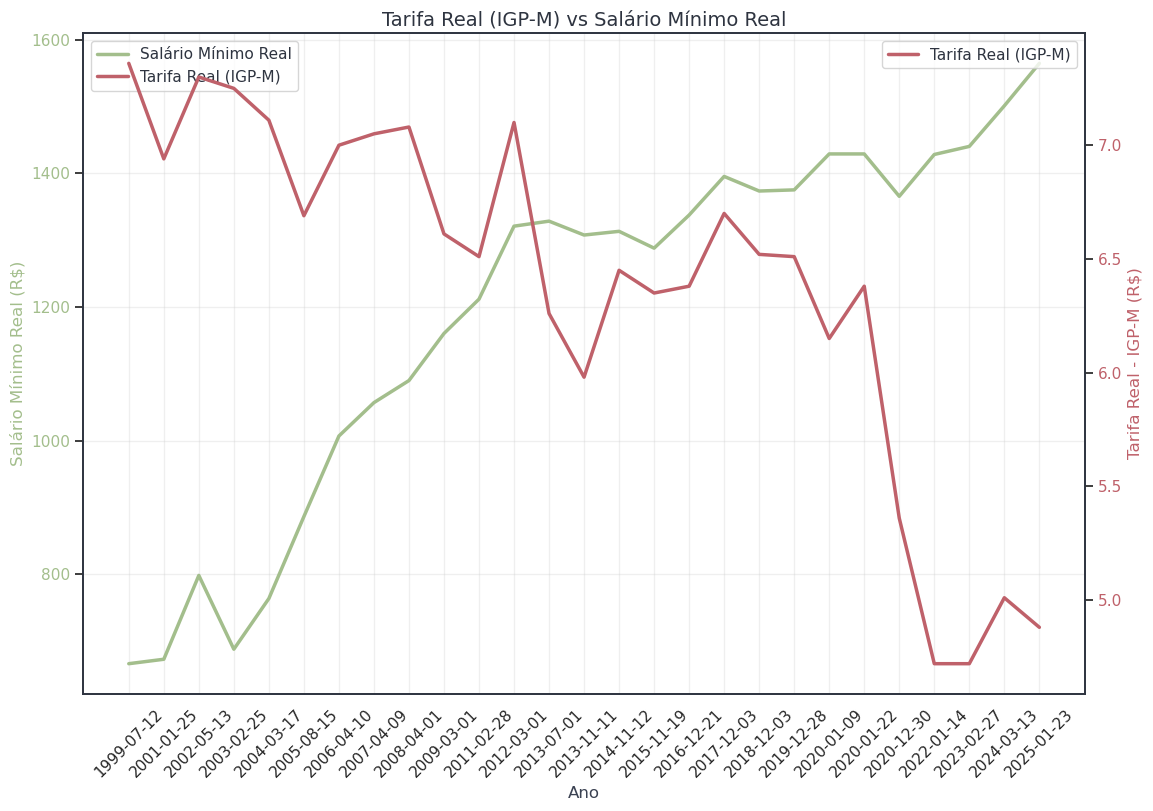

In [12]:
fig, ax1 = plt.subplots(figsize=(11.69, 8.27))

# Primeiro eixo y (esquerda) - Salário Mínimo Real
sns.lineplot(data=df, x='data', y='salario_minimo_real', 
             label='Salário Mínimo Real', linewidth=2.5, color=nord_palette[14], ax=ax1)
ax1.set_ylabel('Salário Mínimo Real (R$)', fontsize=12, color=nord_palette[14])
ax1.tick_params(axis='y', labelcolor=nord_palette[14])

# Segundo eixo y (direita) - Tarifa Real (IGP-M)
ax2 = ax1.twinx()
sns.lineplot(data=df, x='data', y='valor_tarifa_real_igpm', 
             label='Tarifa Real (IGP-M)', linewidth=2.5, color=nord_palette[11], ax=ax2)
ax2.set_ylabel('Tarifa Real - IGP-M (R$)', fontsize=12, color=nord_palette[11])
ax2.tick_params(axis='y', labelcolor=nord_palette[11])

plt.title('Tarifa Real (IGP-M) vs Salário Mínimo Real', fontsize=14)
ax1.set_xlabel('Ano', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Combinar as legendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('imagens/tarifa_real_vs_salario_real_dois_eixos.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Percentual da tarifa sobre o salário mínimo

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


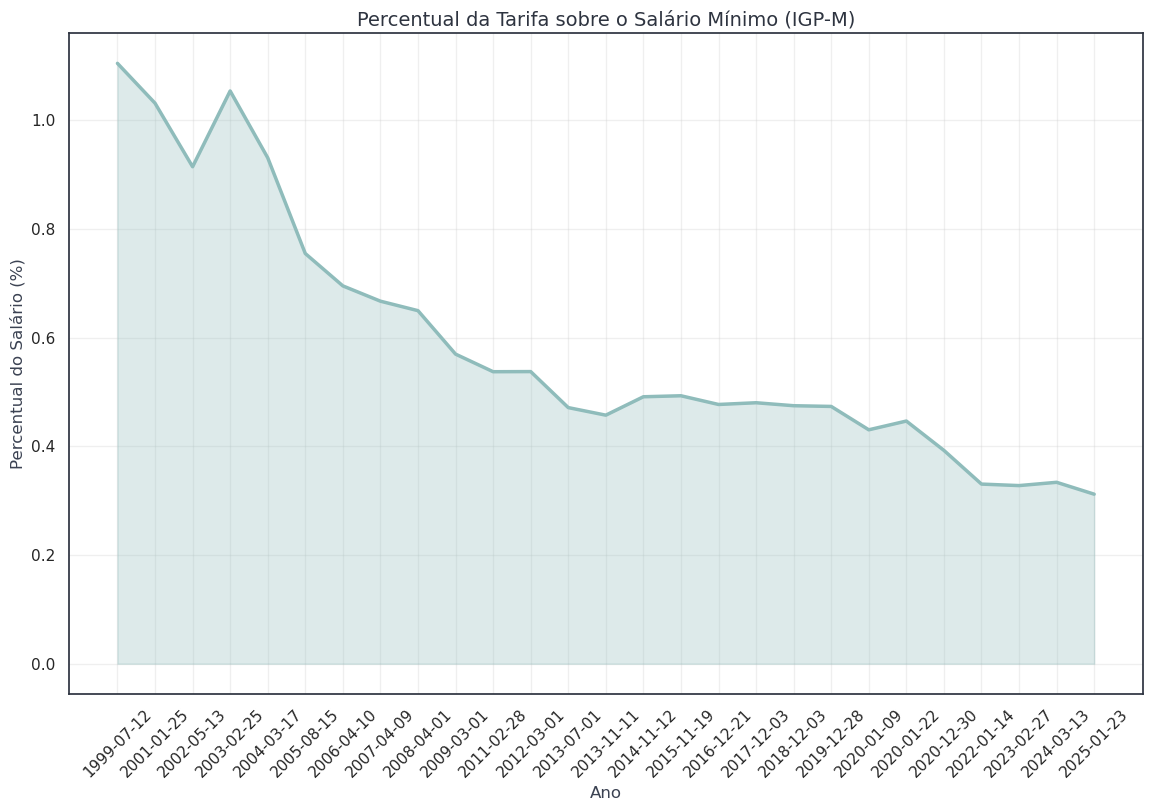

In [11]:
plt.figure(figsize=(11.69, 8.27))
sns.lineplot(data=df, x='data', y='tarifa_real_igpm_sobre_salario_percentual', 
             linewidth=2.5, color=nord_palette[7])
plt.fill_between(df['data'], df['tarifa_real_igpm_sobre_salario_percentual'], 
                 alpha=0.3, color=nord_palette[7])
plt.title('Percentual da Tarifa sobre o Salário Mínimo (IGP-M)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Percentual do Salário (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('imagens/percentual_tarifa_sobre_salario.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Maiores variações percentuais da tarifa de ônibus

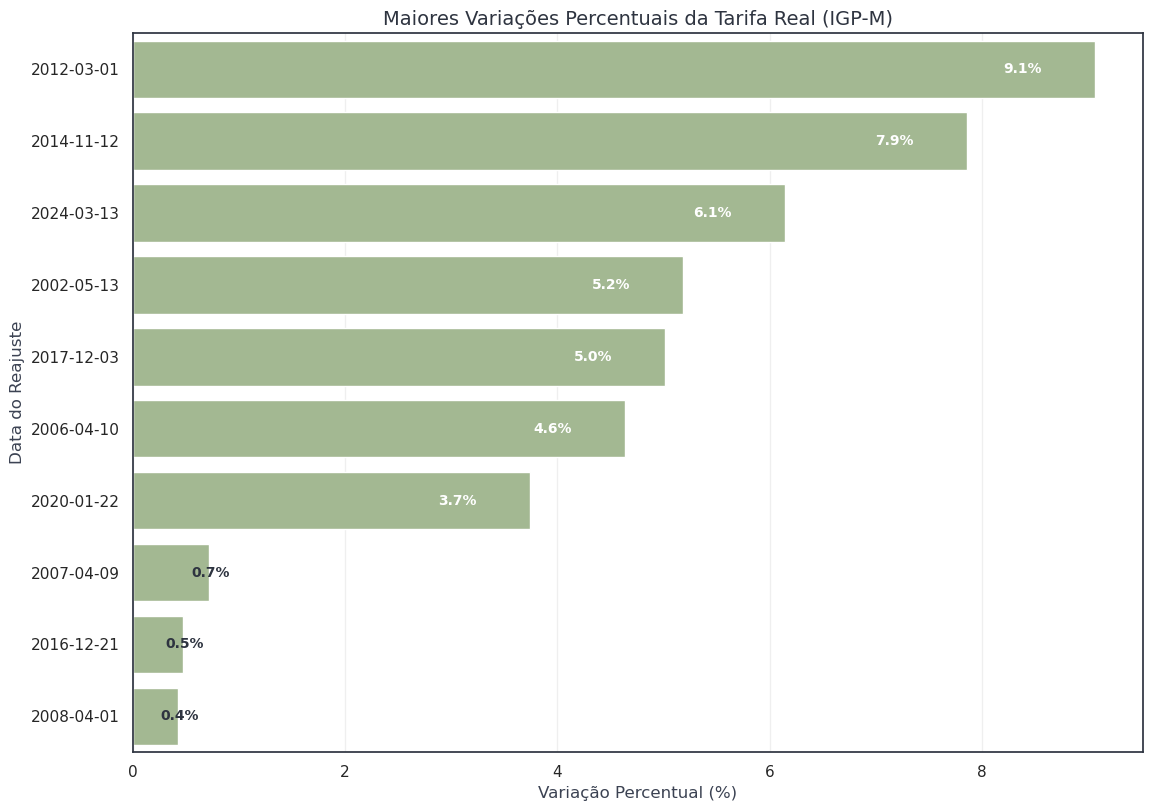

In [14]:
plt.figure(figsize=(11.69, 8.27))

# Filtrar apenas as linhas com variação percentual (remover NaN)
df_variacoes = df[df['variacao_percentual_real_igpm'].notna()].copy()

# Ordenar por valor absoluto da variação e pegar as 10 maiores
df_top_variacoes = df_variacoes.nlargest(10, 'variacao_percentual_real_igpm', keep='all')

# Criar paleta de cores baseada no sinal da variação
cores = [nord_palette[14] if x >= 0 else nord_palette[11] for x in df_top_variacoes['variacao_percentual_real_igpm']]

# Plotar gráfico de barras horizontais
bars = sns.barplot(data=df_top_variacoes, y='data', x='variacao_percentual_real_igpm', palette=cores)

plt.title('Maiores Variações Percentuais da Tarifa Real (IGP-M)', fontsize=14)
plt.xlabel('Variação Percentual (%)', fontsize=12)
plt.ylabel('Data do Reajuste', fontsize=12)

# Adicionar valores dentro das barras
for i, (bar, v) in enumerate(zip(bars.patches, df_top_variacoes['variacao_percentual_real_igpm'])):
    width = bar.get_width()
    # Posicionar o texto dentro da barra
    if v >= 0:
        # Para barras positivas, colocar texto no final da barra (direita)
        x_pos = width - 0.5 if width > 2 else width + 0.2
        text_color = 'white' if width > 2 else nord_palette[0]
        ha = 'right'
    else:
        # Para barras negativas, colocar texto no início da barra (esquerda)
        x_pos = width + 0.5 if abs(width) > 2 else width - 0.5
        text_color = 'white' if abs(width) > 2 else nord_palette[0]
        ha = 'left'
    
    plt.text(x_pos, bar.get_y() + bar.get_height()/2, f'{v:.1f}%', 
             ha=ha, va='center', fontsize=10, color=text_color, fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('imagens/maiores_variacoes_percentuais.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Tarifa real vs salário mínimo

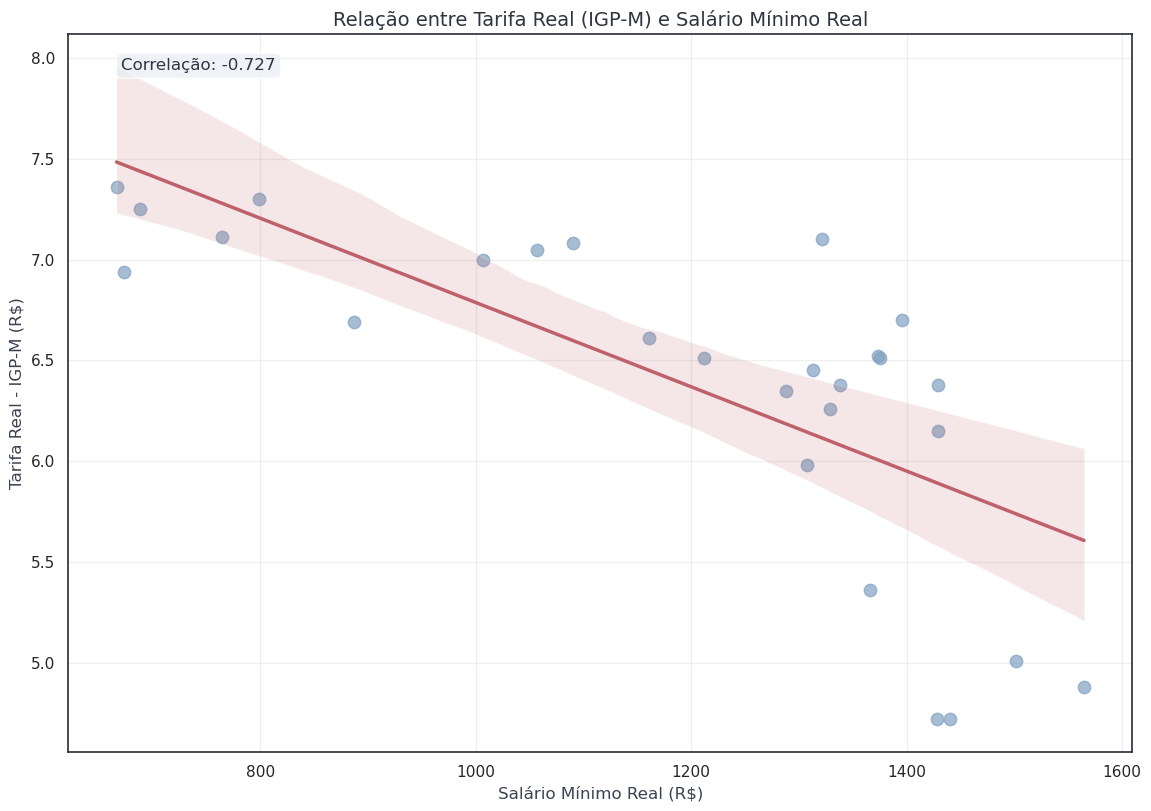

In [15]:
plt.figure(figsize=(11.69, 8.27))
scatter = sns.regplot(data=df, x='salario_minimo_real', y='valor_tarifa_real_igpm', 
                      scatter_kws={'s': 80, 'alpha': 0.7, 'color': nord_palette[9]},
                      line_kws={'color': nord_palette[11], 'linewidth': 2.5})

# Calcular e exibir coeficiente de correlação
correlation = df['salario_minimo_real'].corr(df['valor_tarifa_real_igpm'])
plt.text(0.05, 0.95, f'Correlação: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=nord_palette[6], alpha=0.8))

plt.title('Relação entre Tarifa Real (IGP-M) e Salário Mínimo Real', fontsize=14)
plt.xlabel('Salário Mínimo Real (R$)', fontsize=12)
plt.ylabel('Tarifa Real - IGP-M (R$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('imagens/scatter_tarifa_vs_salario.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Variação vs Magnitude dos reajustes

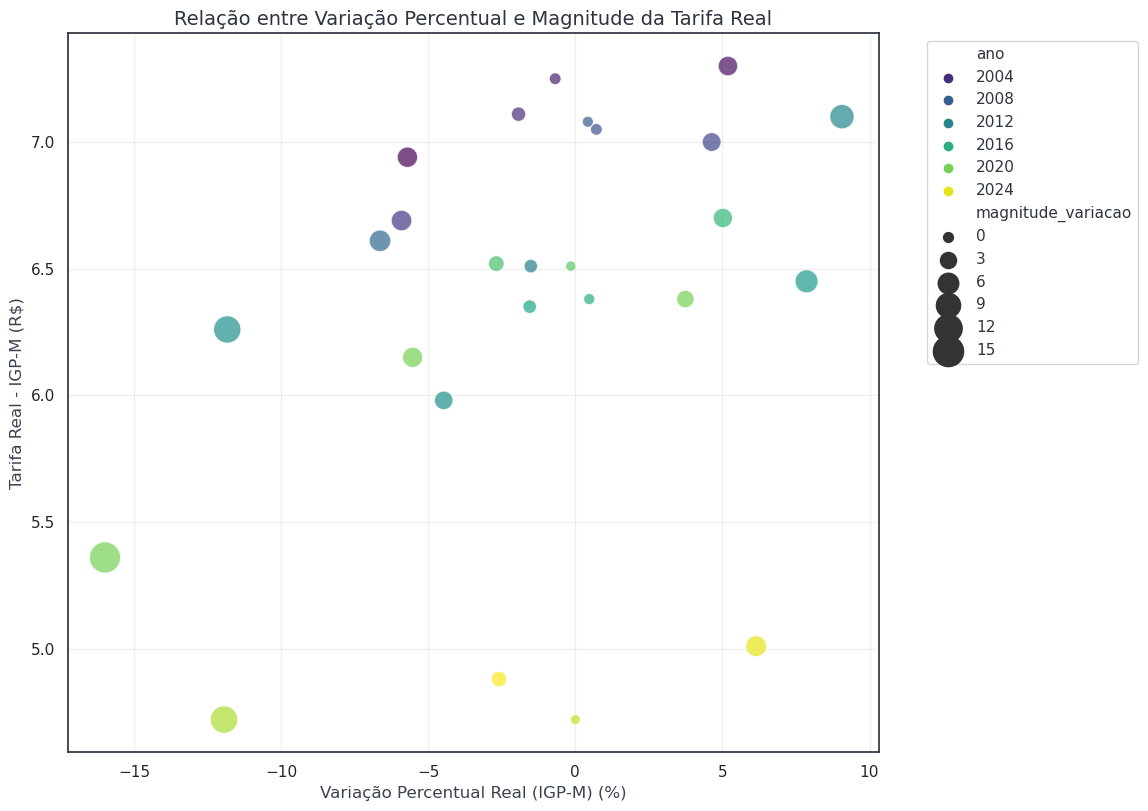

In [17]:
plt.figure(figsize=(11.69, 8.27))

df_bubble = df[df['variacao_percentual_real_igpm'].notna()].copy()
df_bubble['magnitude_variacao'] = abs(df_bubble['variacao_percentual_real_igpm'])

scatter = sns.scatterplot(data=df_bubble, 
                         x='variacao_percentual_real_igpm', 
                         y='valor_tarifa_real_igpm',
                         size='magnitude_variacao',
                         hue='ano',
                         sizes=(50, 500),
                         alpha=0.7,
                         palette='viridis')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Relação entre Variação Percentual e Magnitude da Tarifa Real', fontsize=14)
plt.xlabel('Variação Percentual Real (IGP-M) (%)', fontsize=12)
plt.ylabel('Tarifa Real - IGP-M (R$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('imagens/bubble_variacao_vs_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Gráfico de ponte (waterfall) - acumulado de variações

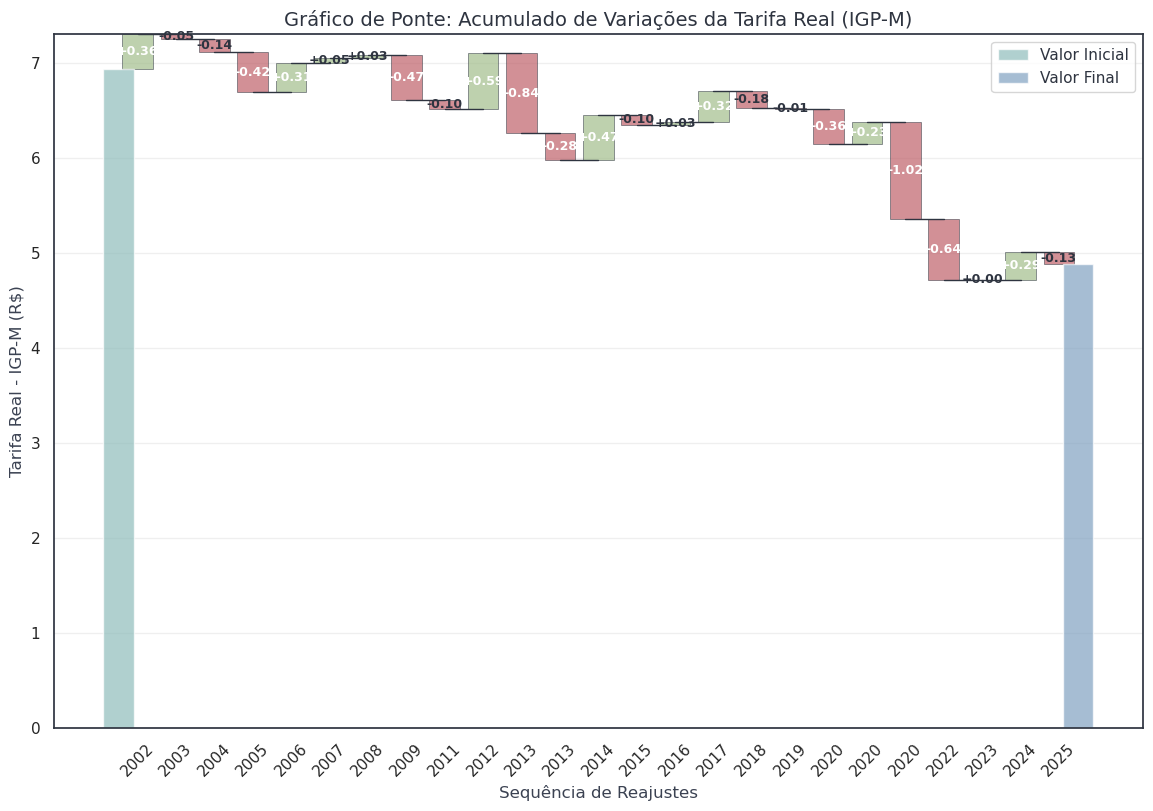

In [19]:
plt.figure(figsize=(11.69, 8.27))

df_waterfall = df[df['variacao_percentual_real_igpm'].notna()].copy()
df_waterfall['data'] = pd.to_datetime(df_waterfall['data']) 
df_waterfall = df_waterfall.reset_index(drop=True)

valores_finais = []
valores_iniciais = []
contribuicoes = []

valor_acumulado = df_waterfall['valor_tarifa_real_igpm'].iloc[0]

for i in range(len(df_waterfall)):
    if i > 0:
        variacao = df_waterfall['variacao_percentual_real_igpm'].iloc[i]
        valor_anterior = df_waterfall['valor_tarifa_real_igpm'].iloc[i-1]
        valor_atual = df_waterfall['valor_tarifa_real_igpm'].iloc[i]
        
        contribuicao = valor_atual - valor_anterior
        valores_iniciais.append(valor_acumulado)
        valores_finais.append(valor_acumulado + contribuicao)
        contribuicoes.append(contribuicao)
        valor_acumulado += contribuicao

for i, (inicio, fim, contrib) in enumerate(zip(valores_iniciais, valores_finais, contribuicoes)):
    cor = nord_palette[14] if contrib >= 0 else nord_palette[11]
    
    # Barra da contribuição
    plt.bar(i, contrib, bottom=inicio, color=cor, alpha=0.7, 
            edgecolor=nord_palette[0], linewidth=0.5)
    
    # Linha conectando as barras
    if i < len(valores_iniciais) - 1:
        plt.plot([i, i+1], [fim, valores_iniciais[i+1]], 
                color=nord_palette[0], linestyle='-', linewidth=1)

plt.bar(-0.5, df_waterfall['valor_tarifa_real_igpm'].iloc[0], 
        color=nord_palette[7], alpha=0.7, label='Valor Inicial')
plt.bar(len(contribuicoes)-0.5, df_waterfall['valor_tarifa_real_igpm'].iloc[-1], 
        color=nord_palette[9], alpha=0.7, label='Valor Final')

plt.title('Gráfico de Ponte: Acumulado de Variações da Tarifa Real (IGP-M)', fontsize=14)
plt.xlabel('Sequência de Reajustes', fontsize=12)
plt.ylabel('Tarifa Real - IGP-M (R$)', fontsize=12)

datas = [f"{df_waterfall['data'].iloc[i].year}" for i in range(1, len(df_waterfall))]
plt.xticks(range(len(datas)), datas, rotation=45)

for i, (inicio, fim, contrib) in enumerate(zip(valores_iniciais, valores_finais, contribuicoes)):
    plt.text(i, (inicio + fim) / 2, f'{contrib:+.2f}', 
             ha='center', va='center', fontsize=9, fontweight='bold',
             color='white' if abs(contrib) > 0.2 else nord_palette[0])

plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('imagens/waterfall_acumulado_variacoes.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Linha com média móvel - tendência de longo prazo

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

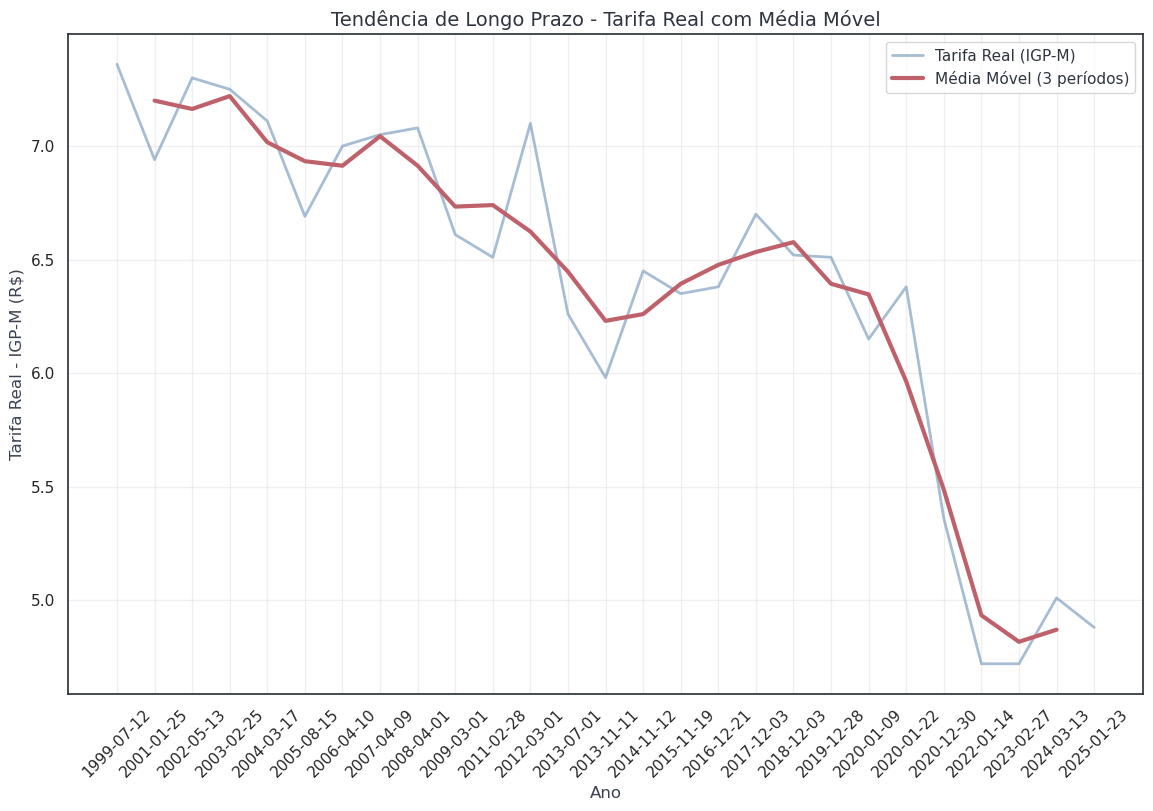

In [20]:
plt.figure(figsize=(11.69, 8.27))

df_ma = df.copy()
df_ma['media_movel'] = df_ma['valor_tarifa_real_igpm'].rolling(window=3, center=True).mean()

sns.lineplot(data=df_ma, x='data', y='valor_tarifa_real_igpm', 
             label='Tarifa Real (IGP-M)', linewidth=2, alpha=0.7, color=nord_palette[9])
sns.lineplot(data=df_ma, x='data', y='media_movel', 
             label='Média Móvel (3 períodos)', linewidth=3, color=nord_palette[11])

plt.title('Tendência de Longo Prazo - Tarifa Real com Média Móvel', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Tarifa Real - IGP-M (R$)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('imagens/media_movel_tendencia.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Gráfico de decomposição temporal - tendência, sazonalidade e resíduo

<Figure size 1169x1000 with 0 Axes>

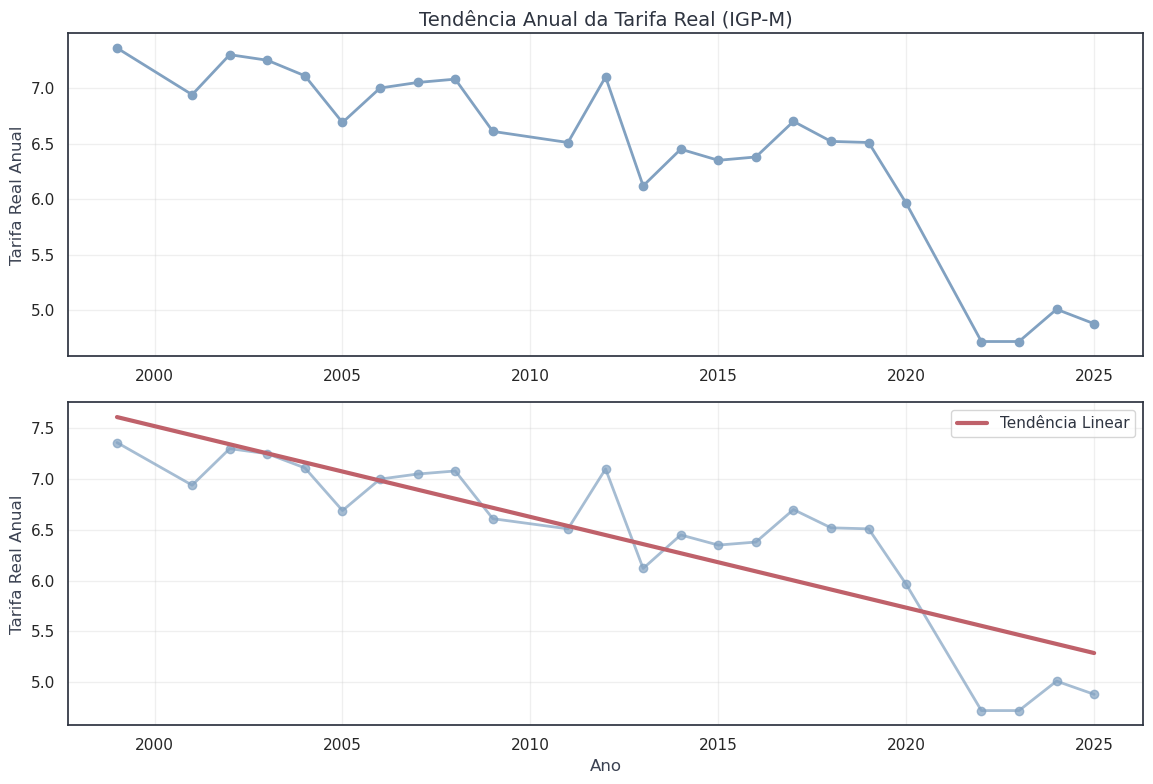

In [24]:
plt.figure(figsize=(11.69, 10))

# Agrupar por ano para suavizar
df_annual = df.groupby('ano')['valor_tarifa_real_igpm'].mean().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(11.69, 8))

# Série original anual
axes[0].plot(df_annual['ano'], df_annual['valor_tarifa_real_igpm'], 
            marker='o', color=nord_palette[9], linewidth=2)
axes[0].set_ylabel('Tarifa Real Anual', fontsize=12)
axes[0].set_title('Tendência Anual da Tarifa Real (IGP-M)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Tendência linear
z = np.polyfit(df_annual['ano'], df_annual['valor_tarifa_real_igpm'], 1)
p = np.poly1d(z)
axes[1].plot(df_annual['ano'], df_annual['valor_tarifa_real_igpm'], 
            marker='o', color=nord_palette[9], linewidth=2, alpha=0.7)
axes[1].plot(df_annual['ano'], p(df_annual['ano']), 
            color=nord_palette[11], linewidth=3, label='Tendência Linear')
axes[1].set_ylabel('Tarifa Real Anual', fontsize=12)
axes[1].set_xlabel('Ano', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('imagens/tendencia_anual_simplificada.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Linha - Tarifa real vs Inflação acumulada

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

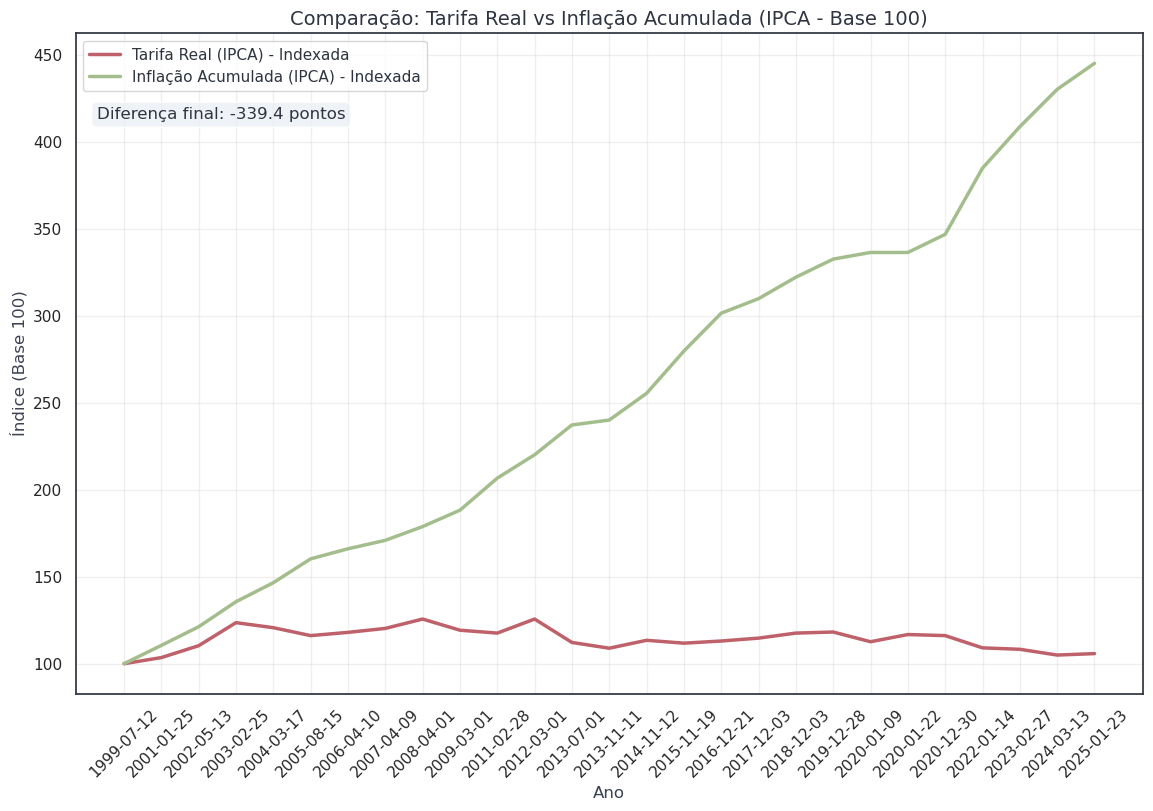

In [34]:
plt.figure(figsize=(11.69, 8.27))

# Calcular inflação acumulada (IPCA) a partir das variações mensais
df_inflacao = df.copy()
df_inflacao['inflacao_acumulada'] = (1 + df_inflacao['ipca_variacao_mensal_acumulada'].fillna(0) / 100).cumprod() * 100

# Normalizar as séries para base 100 no primeiro ponto 
base_tarifa = df_inflacao['valor_tarifa_real_ipca'].iloc[0]
base_inflacao = df_inflacao['inflacao_acumulada'].iloc[0]

df_inflacao['tarifa_indexada'] = (df_inflacao['valor_tarifa_real_ipca'] / base_tarifa) * 100
df_inflacao['inflacao_indexada'] = (df_inflacao['inflacao_acumulada'] / base_inflacao) * 100

sns.lineplot(data=df_inflacao, x='data', y='tarifa_indexada', 
             label='Tarifa Real (IPCA) - Indexada', linewidth=2.5, color=nord_palette[11])
sns.lineplot(data=df_inflacao, x='data', y='inflacao_indexada', 
             label='Inflação Acumulada (IPCA) - Indexada', linewidth=2.5, color=nord_palette[14])

plt.title('Comparação: Tarifa Real vs Inflação Acumulada (IPCA - Base 100)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Índice (Base 100)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

diff_final = df_inflacao['tarifa_indexada'].iloc[-1] - df_inflacao['inflacao_indexada'].iloc[-1]
plt.text(0.02, 0.87, f'Diferença final: {diff_final:+.1f} pontos', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor=nord_palette[6], alpha=0.8))

plt.tight_layout()
plt.savefig('imagens/tarifa_vs_inflacao_ipca.png', dpi=300, bbox_inches='tight')
plt.show()

### Análise da relação tarifa-inflação (IPCA)

In [37]:
print("Análise da Relação Tarifa vs Inflação (IPCA):")
print("="*50)

crescimento_tarifa_ipca = (df_inflacao['valor_tarifa_real_ipca'].iloc[-1] / df_inflacao['valor_tarifa_real_ipca'].iloc[0] - 1) * 100
crescimento_inflacao = (df_inflacao['inflacao_acumulada'].iloc[-1] / 100 - 1) * 100 

print(f"Crescimento da tarifa real (IPCA): {crescimento_tarifa_ipca:.1f}%")
print(f"Crescimento da inflação (IPCA): {crescimento_inflacao:.1f}%")
print(f"Diferença: {crescimento_tarifa_ipca - crescimento_inflacao:.1f} pontos percentuais")

correlacao_ipca = df_inflacao['valor_tarifa_real_ipca'].corr(df_inflacao['inflacao_acumulada'])
print(f"Correlação entre tarifa real (IPCA) e inflação (IPCA): {correlacao_ipca:.3f}")

if crescimento_tarifa_ipca > crescimento_inflacao:
    print("A tarifa real cresceu MAIS que a inflação geral.")
elif crescimento_tarifa_ipca < crescimento_inflacao:
    print("A tarifa real cresceu MENOS que a inflação geral.")
else:
    print("A tarifa real acompanhou exatamente a inflação geral.")

Análise da Relação Tarifa vs Inflação (IPCA):
Crescimento da tarifa real (IPCA): 5.8%
Crescimento da inflação (IPCA): 345.2%
Diferença: -339.4 pontos percentuais
Correlação entre tarifa real (IPCA) e inflação (IPCA): -0.249
A tarifa real cresceu MENOS que a inflação geral.


## 10. Comparação do aumento percentual - tarifa nominal vs salário mínimo

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


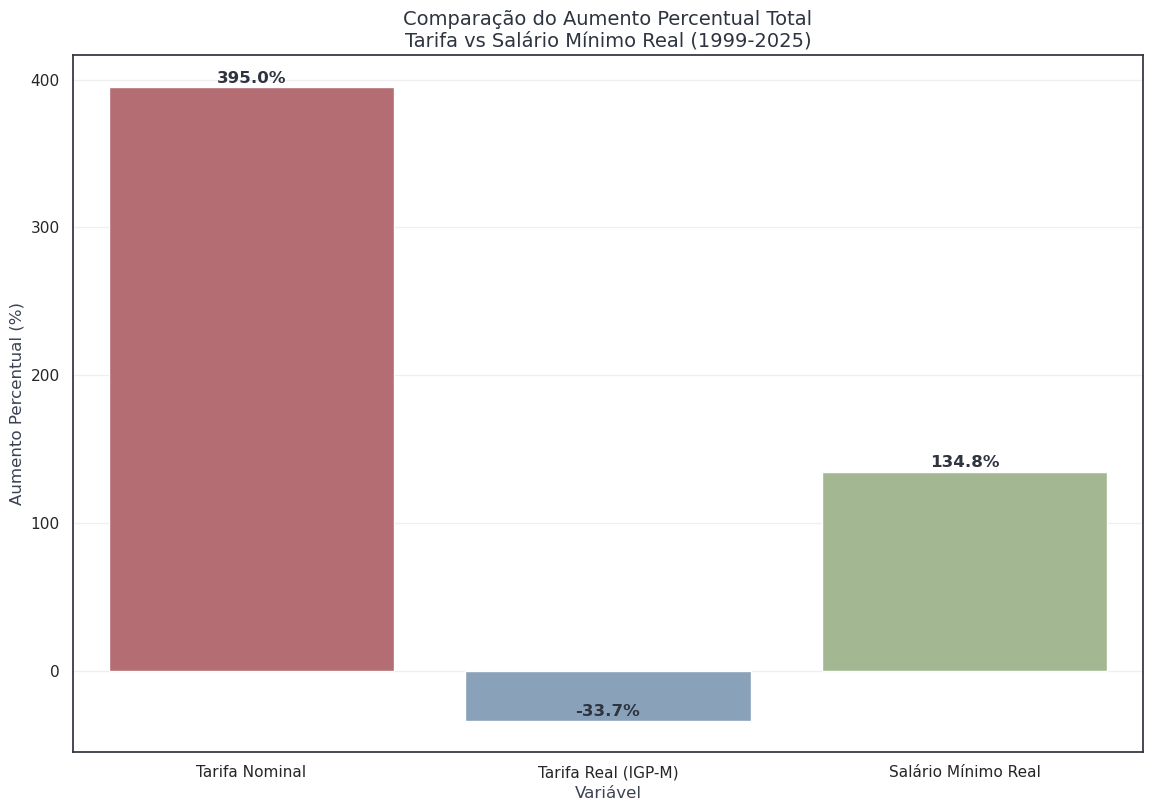

Análise Comparativa dos Aumentos Percentuais:
Tarifa nominal: 1.00 → 4.95 (+395.0%)
Tarifa real (IGP-M): 7.36 → 4.88 (-33.7%)
Salário mínimo real: 666.37 → 1564.78 (+134.8%)
Diferença tarifa nominal vs salário: 260.2 pontos percentuais
Diferença tarifa real vs salário: -168.5 pontos percentuais


In [7]:
plt.figure(figsize=(11.69, 8.27))

df['data'] = pd.to_datetime(df['data'])

aumento_tarifa_nominal = ((df['valor_tarifa'].iloc[-1] / df['valor_tarifa'].iloc[0]) - 1) * 100
aumento_tarifa_real = ((df['valor_tarifa_real_igpm'].iloc[-1] / df['valor_tarifa_real_igpm'].iloc[0]) - 1) * 100
aumento_salario_real = ((df['salario_minimo_real'].iloc[-1] / df['salario_minimo_real'].iloc[0]) - 1) * 100

categorias = ['Tarifa Nominal', 'Tarifa Real (IGP-M)', 'Salário Mínimo Real']
valores = [aumento_tarifa_nominal, aumento_tarifa_real, aumento_salario_real]
cores = [nord_palette[11], nord_palette[9], nord_palette[14]]

bars = sns.barplot(x=categorias, y=valores, palette=cores)

plt.title('Comparação do Aumento Percentual Total\nTarifa vs Salário Mínimo Real (1999-2025)', fontsize=14)
plt.ylabel('Aumento Percentual (%)', fontsize=12)
plt.xlabel('Variável', fontsize=12)

for i, v in enumerate(valores):
    bars.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('imagens/comparacao_aumento_percentual_tres_barras.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise numérica complementar
print("Análise Comparativa dos Aumentos Percentuais:")
print("="*50)
print(f"Tarifa nominal: {df['valor_tarifa'].iloc[0]:.2f} → {df['valor_tarifa'].iloc[-1]:.2f} (+{aumento_tarifa_nominal:.1f}%)")
print(f"Tarifa real (IGP-M): {df['valor_tarifa_real_igpm'].iloc[0]:.2f} → {df['valor_tarifa_real_igpm'].iloc[-1]:.2f} ({aumento_tarifa_real:.1f}%)")
print(f"Salário mínimo real: {df['salario_minimo_real'].iloc[0]:.2f} → {df['salario_minimo_real'].iloc[-1]:.2f} (+{aumento_salario_real:.1f}%)")
print(f"Diferença tarifa nominal vs salário: {aumento_tarifa_nominal - aumento_salario_real:.1f} pontos percentuais")
print(f"Diferença tarifa real vs salário: {aumento_tarifa_real - aumento_salario_real:.1f} pontos percentuais")